
# LendingClub Accepted Loans EDA

In [1]:
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,4)

# --- CONFIG ---
ACCEPTED_PATH = "../data/accepted_2007_to_2018Q4.csv" 

RANDOM_SEED = 42
OUTDIR = "./lc_accepted_outputs"

# Create output dir
import os
os.makedirs(OUTDIR, exist_ok=True)
print("Output directory:", OUTDIR)

Output directory: ./lc_accepted_outputs


### Feature Choice (based on data dictionary `LCDataDictionary.xlsx`)

| Feature | Justification |
| :--- | :--- |
| `loan_amnt` | Exposure size; larger loans increase LGD and repayment strain. |
| `term` | Longer terms increase duration risk and PD. |
| `int_rate` | Risk-based pricing + affordability headroom. |
| `grade` | Macro risk bucket from underwriting; strong PD signal. |
| `sub_grade` | Finer risk granularity; typically monotonic with PD. |
| `fico_range_low` | Lower bound credit quality signal. |
| `fico_range_high` | Upper bound; captures range/uncertainty. |
| `annual_inc` | Capacity to repay (with caveats on self-report). |
| `dti` | Leverage/affordability; higher often → higher PD. |
| `revol_util` | Credit strain indicator. |
| `emp_length` | Income stability proxy. |
| `home_ownership` | Tenure/asset proxy; often lower PD. |
| `verification_status`| Mitigates misstatement risk. |
| `purpose` | Use-of-funds segment risk differences. |
| `issue_d` | Vintage/macro & policy drift control. |

In [2]:
# list of features to be used from the dataset for analysis
FEATURES = [
    "loan_amnt", "term", "int_rate",
    "grade", "sub_grade",
    "fico_range_low", "fico_range_high",
    "annual_inc", "dti", "revol_util",
    "emp_length", "home_ownership", "verification_status",
    "purpose", "issue_d",
]

# loan statuses that are considered negative outcomes (defaults).
BAD_STATUSES = {
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Does not meet the credit policy. Status:Charged Off",
}
# loan statuses that are considered positive outcomes.
GOOD_STATUSES = {
    "Fully Paid",
    "Current",
}

### Data Cleaning and Feature Engineering Functions

In [3]:
# This function parses a issue_d into a datetime object.
def parse_issue_date(s):
    # If the input is Not a Number (NaN), return Not a Time (NaT).
    if pd.isna(s): return pd.NaT
    # Tries to parse the date with a specific format ('Mon-YYYY', e.g., 'Jan-2024') first,
    # then with pandas' default parser.
    for fmt in ["%b-%Y", None]:
        try:
            # Attempt to convert the string 's' to a datetime object.
            return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)
        except Exception:
            # If parsing fails, move to the next format.
            pass
    # If all parsing attempts fail, return Not a Time.
    return pd.NaT

# This function creates a binary 'default' flag (1 for bad, 0 for good) from a loan status.
def make_default_flag(status):
    # If the status is in the BAD_STATUSES set, return 1 (indicating default).
    if status in BAD_STATUSES: return 1
    # If the status is in the GOOD_STATUSES set, return 0 (indicating non-default).
    if status in GOOD_STATUSES: return 0
    # For any other status (ambiguous), return NaN so it can be filtered out later.
    return np.nan

# This function caps outliers in a numerical column. (winsorizing)
def cap_outliers(series, lower_q=0.01, upper_q=0.99):
    # Calculate the lower and upper percentile values (e.g., 1st and 99th percentiles).
    lo, hi = series.quantile(lower_q), series.quantile(upper_q)
    # Replace all values below 'lo' with 'lo' and all values above 'hi' with 'hi'.
    return series.clip(lo, hi)

# This function creates a boolean mask to filter for data from the most recent 2 years.
def recent_2y_mask(df, date_col):
    # Find the latest date in the specified date column.
    maxd = df[date_col].max()
    # If there are no valid dates, return a series of False values.
    if pd.isna(maxd): 
        return pd.Series(False, index=df.index)
    # Calculate the cutoff date, which is 24 months before the latest date.
    cutoff = maxd - pd.DateOffset(months=23)
    # Return a boolean Series: True if the date is at or after the cutoff, otherwise False.
    return df[date_col] >= cutoff

# This function cleans and converts the 'employment length' column to a numerical format.
def parse_emp_length(x):
    # Handle missing values.
    if pd.isna(x): return np.nan
    s = str(x).strip().lower() # Standardize the string: remove whitespace and make it lowercase.
    # Handle common non-numeric entries.
    if s in {"n/a", "na", "none"}: return np.nan
    if s == "< 1 year": return 0.5 # Represent less than 1 year as 0.5.
    if "10+" in s: return 10.0 # Represent 10+ years as 10.
    # Extract only the digits from the string (e.g., "5 years" becomes "5").
    digits = "".join(ch for ch in s if ch.isdigit() or ch == ".")
    try:
        # Convert the extracted digits to a float.
        return float(digits)
    except:
        # If conversion fails for any reason, return NaN.
        return np.nan

In [8]:
# --- Load accepted: restrict to focused columns + label ---
usecols = set(FEATURES + ["loan_status","id","member_id"])
accepted = pd.read_csv(ACCEPTED_PATH, usecols=lambda c: c in usecols, low_memory=False)
accepted.shape

(2260701, 18)

In [9]:

# --- Cleaning / labeling ---
accepted["issue_d"] = accepted["issue_d"].apply(parse_issue_date)
accepted["default_flag"] = accepted["loan_status"].apply(make_default_flag)
accepted = accepted[~accepted["default_flag"].isna()].copy()

# Numeric coercions
for col in ["loan_amnt","int_rate","annual_inc","dti","revol_util","fico_range_low","fico_range_high"]:
    if col in accepted.columns:
        if accepted[col].dtype == "O" and col in {"int_rate","revol_util"}:
            accepted[col] = accepted[col].astype(str).str.replace("%","", regex=False)
        accepted[col] = pd.to_numeric(accepted[col], errors="coerce")

# Engineering
accepted["emp_length_num"] = accepted["emp_length"].apply(parse_emp_length) if "emp_length" in accepted.columns else np.nan
accepted["term_num"] = accepted["term"].astype(str).str.extract(r"(\d+)").astype(float)

# Winsorize key skewed fields
for col in ["annual_inc","dti","revol_util","int_rate","loan_amnt"]:
    if col in accepted.columns:
        accepted[col] = cap_outliers(accepted[col])

# --- Subset rule (fixed): last 2y THEN random 50k ---
mask_last2y = recent_2y_mask(accepted, "issue_d")
acc_last2y = accepted.loc[mask_last2y].copy()
acc_sub = acc_last2y.sample(n=min(50000, len(acc_last2y)), random_state=RANDOM_SEED).copy()

# Row completeness gate (>=70% over chosen features + engineered)
feat_cols = [c for c in FEATURES if c in acc_sub.columns] + ["default_flag","emp_length_num","term_num"]
completeness = acc_sub[feat_cols].notna().mean(axis=1)
acc_sub = acc_sub.loc[completeness >= 0.7].copy()

acc_sub.to_csv(Path(OUTDIR, "accepted_subset_clean.csv"), index=False)
acc_sub.shape, acc_sub["default_flag"].mean()


((50000, 21), np.float64(0.0687))

## BASIC QA + SUMMARY

In [7]:
num_cols = ["loan_amnt","int_rate","fico_range_low","fico_range_high","fico_mid",
            "annual_inc","dti","revol_util","term_m","emp_years"]
num_cols = [c for c in num_cols if c in acc_sub.columns]
cat_cols = ["grade","sub_grade","home_ownership","verification_status","purpose","term"]
cat_cols = [c for c in cat_cols if c in acc_sub.columns]

qa = pd.DataFrame({
    "column": num_cols + cat_cols,
    "missing_%": [(acc_sub[c].isna().mean()*100) for c in (num_cols + cat_cols)],
    "n_unique": [acc_sub[c].nunique() for c in (num_cols + cat_cols)]
})

In [8]:
display(qa.sort_values("missing_%", ascending=False).head(20))

,column,missing_%,n_unique
5,dti,0.188,3906
6,revol_util,0.110,973
2,fico_range_low,0.000,38
1,int_rate,0.000,123
0,loan_amnt,0.000,1286
4,annual_inc,0.000,4551
3,fico_range_high,0.000,38
7,grade,0.000,7
8,sub_grade,0.000,35
9,home_ownership,0.000,4


In [9]:
display(acc_sub[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
loan_amnt,50000.0,15485.308500,9893.541735,1525.00,1525.00,3000.00,8000.00,13000.00,20006.25,35000.00,40000.00,40000.00
int_rate,50000.0,12.890524,5.018889,5.32,5.32,6.11,9.44,11.99,15.99,23.40,26.77,26.77
fico_range_low,50000.0,703.673400,35.240743,660.00,660.00,660.00,675.00,695.00,725.00,775.00,810.00,845.00
fico_range_high,50000.0,707.673640,35.241709,664.00,664.00,664.00,679.00,699.00,729.00,779.00,814.00,850.00
annual_inc,50000.0,77965.777770,46700.088694,16800.00,16800.00,26000.00,46200.00,66000.00,96000.00,170000.00,270000.00,270000.00
dti,49906.0,18.657828,9.330083,1.73,1.73,4.49,11.76,17.82,24.81,35.25,42.62,42.62
revol_util,49945.0,45.667859,24.763183,0.90,0.90,6.70,26.20,44.40,64.10,88.70,97.80,98.10


* **Pricing bands:** Rates center ~**12.9%** (IQR ~9.4–16.0%), with a long tail up to **26.8%** → plenty of room to price for risk.
* **Borrower risk mix:** FICO midpoint ≈ **705** (IQR ~695–729). The **95th pct DTI ≈ 35%** and **75th pct ≈ 24.8%** → accepted book already trims very high DTI, but the tail is meaningful.
* **Leverage stress:** **Revolving util. mean ~46%**, 75th ≈ **64%**, 95th ≈ **88.7%** → a sizable chunk is highly utilized despite being approved.
* **Ticket sizes:** Median loan ≈ **$13k**, 75th ≈ **$20k**, top coded at **$40k** → exposure concentration possible at the top end.

## BUSINESS-FOCUSED TABLES

In [10]:
# Pricing ladder: int_rate by grade / term
if "int_rate" in acc_sub and "grade" in acc_sub:
    piv_price = acc_sub.pivot_table(index="grade", columns="term", values="int_rate", aggfunc="median").sort_index()
    display(piv_price)

term,36 months,60 months
grade,,
A,7.21,7.84
B,10.72,10.49
C,14.08,14.47
D,18.99,19.03
E,24.37,25.49
F,26.77,26.77
G,26.77,26.77


* **Monotonic by grade:** Median rate rises A→G (7.2% → 26.8%). Good price-for-risk signal.
* **Ceiling effect:** F & G are flat at **26.77%** for both terms → looks like a **rate cap**. Risk may be under-priced if losses rise but prices can’t.
* **Tiny term premium overall:** A: **+0.6pp**, C: **+0.4pp**, D: **+0.0pp**, E: **+1.1pp** from 36→60. That’s small given 60-mo duration risk.
* **Oddity in B:** **60-mo (10.49%) < 36-mo (10.72%)** → likely **mix/selection** (e.g., higher-quality B borrowers choosing 60-mo) or data artifact. Worth a deeper cut (e.g., by FICO/DTI within B).


In [11]:
# DTI & FICO by term and sub_grade
for v in ["dti","fico_mid"]:
    if v in acc_sub:
        display(acc_sub.pivot_table(index="sub_grade", columns="term", values=v, aggfunc="median").sort_index())

term,36 months,60 months
sub_grade,,
A1,13.700,14.380
A2,15.070,15.935
A3,15.020,15.495
A4,16.560,14.380
A5,17.200,16.580
B1,16.280,15.775
B2,17.100,15.630
B3,17.180,18.570
B4,17.560,18.280


* **Risk increases** as you move from **A → G** (as expected).
* **60-month loans** are generally **riskier** than 36-month (e.g., F5 27.4% vs 25.6%, G3 27.8% vs 25.2%), with a few quirks (G4 is extreme at **36m = 29.95%** but only 21.29% at 60m).
* There’s a **wide spread** → perfect for **segment-specific policy** (different top-k cuts per segment).


In [12]:
# Income verification effect on rate
if {"verification_status","int_rate"} <= set(acc_sub.columns):
    display(acc_sub.groupby("verification_status")["int_rate"].agg(["count","median","mean"]).sort_values("median"))

,count,median,mean
verification_status,,,
Not Verified,19101,10.90,11.638515
Source Verified,19610,12.61,13.085256
Verified,11289,14.07,14.670658


* Risk is **lowest** for **Not Verified**, **higher** for **Source Verified**, and **highest** for **Verified**.
* This is **not paradoxical**: verification often happens more on applicants who already look riskier (selection effect), so the “Verified” group contains **tougher cases** overall.

In [13]:
# Purpose mix
if "purpose" in acc_sub.columns:
    purpose_share = (acc_sub["purpose"].value_counts(normalize=True)*100).round(2)
    display(purpose_share.to_frame("share_%"))

,share_%
purpose,
debt_consolidation,53.76
credit_card,23.28
other,7.38
home_improvement,7.19
major_purchase,2.34
medical,1.43
car,1.13
small_business,1.04
vacation,0.85


* Highly concentrated: **debt_consolidation (53.8%)** + **credit_card (23.3%)** = **~77%** of all loans.
* Long tail: each of the other categories is **≤ 7%**; several are **≈1%** or less (e.g., small_business, vacation, house, moving, renewable_energy).

### Plot Analysis

In [14]:
# This function plots the average rate of a target variable for each category of a feature.
def plot_rate_by_cat(df, cat, target, outpath):
    # Set a professional style for better aesthetics
    plt.style.use('seaborn-v0_8-whitegrid') 

    # Group the DataFrame by the categorical column 'cat' and calculate the mean of the 'target'.
    # Use reset_index() to make 'cat' a regular column for plotting if needed, 
    # but for a pandas Series plot, the index is used for x-axis.
    rates = df.groupby(cat)[target].mean().sort_values(ascending=False)
    
    # Create a bar plot of the calculated rates.
    # Set a figure size for better aspect ratio and readability
    plt.figure(figsize=(8, 6))
    ax = rates.plot(kind="bar", color='#1f77b4', edgecolor='black', alpha=0.8) # Add color, edge, and slight transparency
    
    # Set the title and labels for the plot.
    ax.set_title(f"Default Rate by {cat.replace('_', ' ').title()}", fontsize=16, fontweight='bold') # Better title formatting
    ax.set_xlabel(cat.replace('_', ' ').title(), fontsize=12); 
    ax.set_ylabel("Default Rate", fontsize=12)

    # Improve layout and readability of x-axis labels.
    plt.xticks(rotation=45, ha="right")
    
    # Make y-axis labels show percentages for clarity
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    
    # Save the plot to a file, display it, and then close the plot to free up memory.
    plt.savefig(outpath, dpi=300) # Increase DPI for higher quality image
    plt.show()
    plt.close()



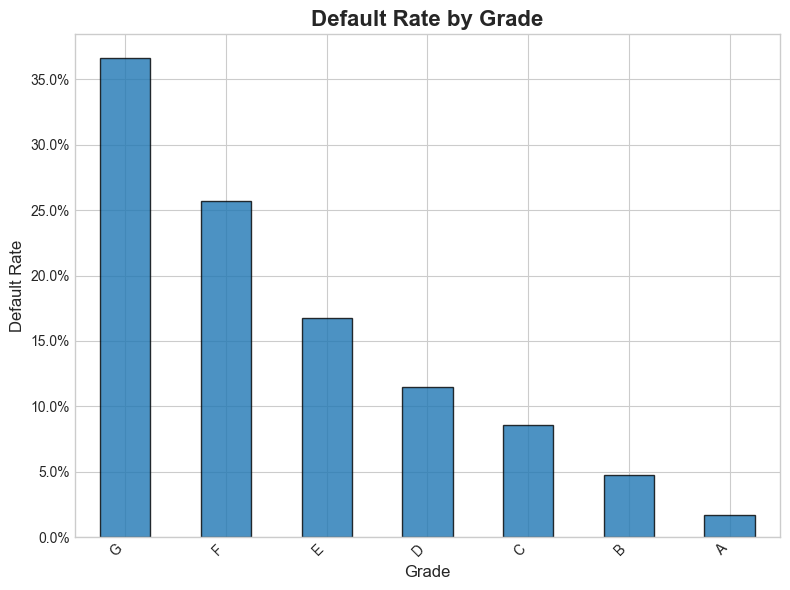

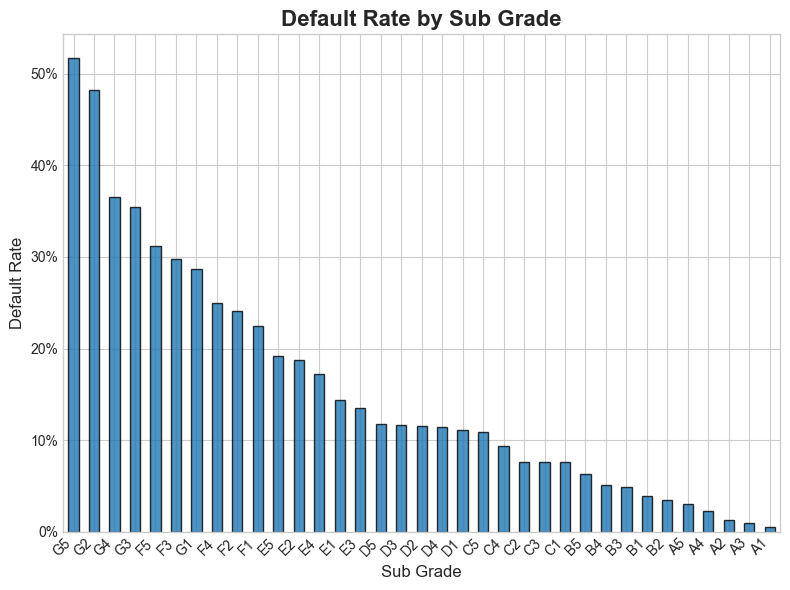

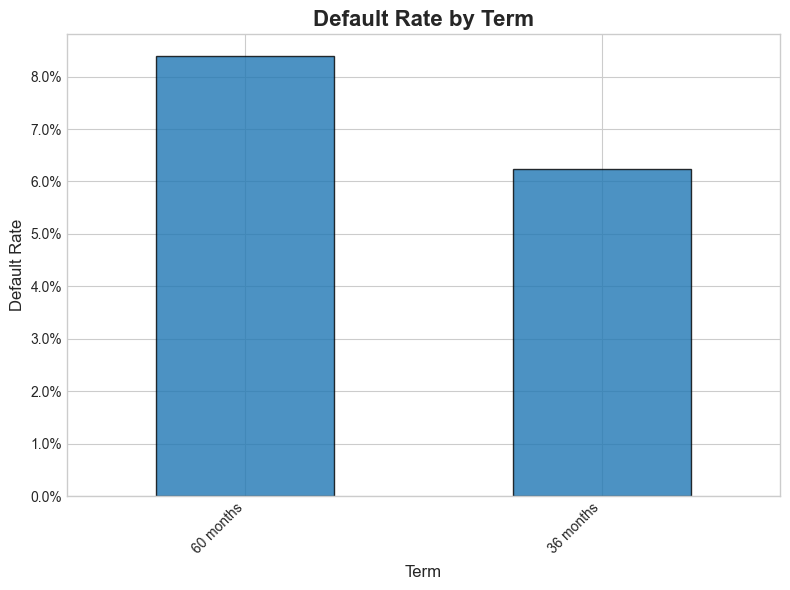

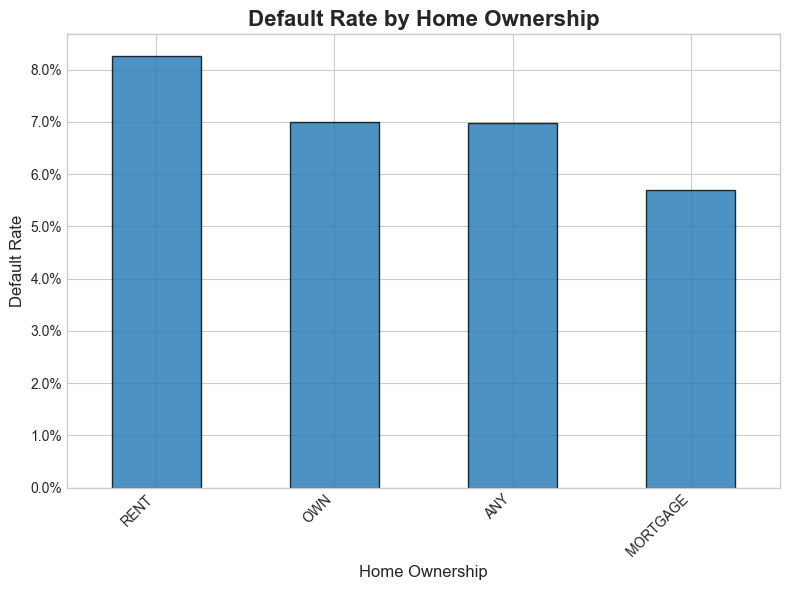

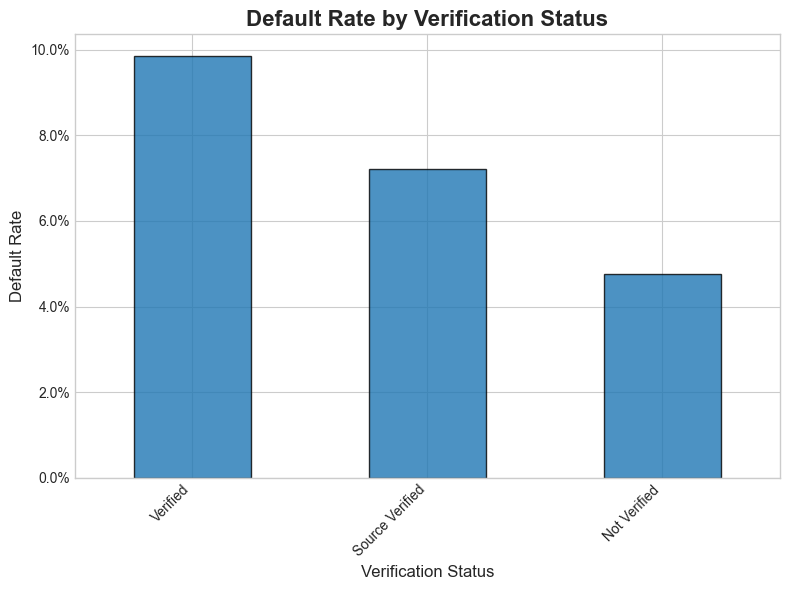

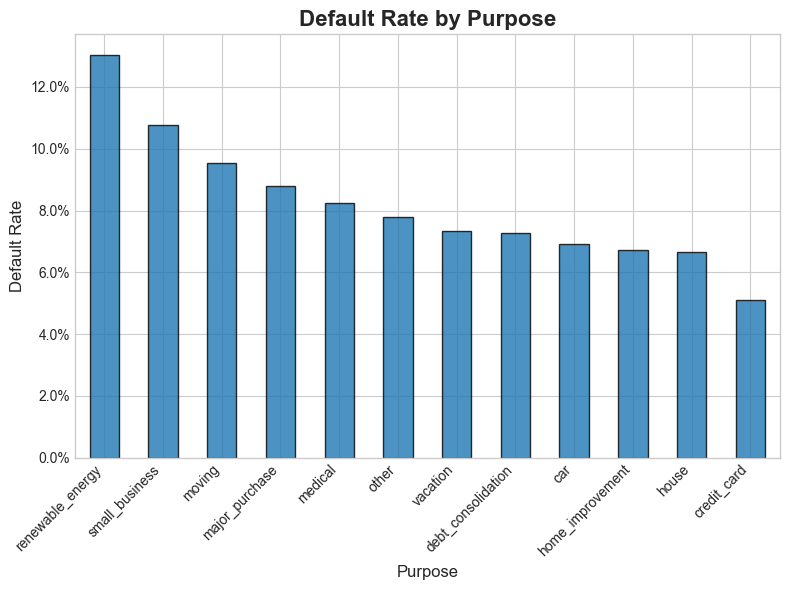

In [15]:
# --- Categorical default rates ---
for cat in ["grade","sub_grade","term","home_ownership","verification_status","purpose"]:
    if cat in acc_sub.columns:
        plot_rate_by_cat(acc_sub, cat, "default_flag", Path(OUTDIR, f"default_rate_by_{cat}.png"))

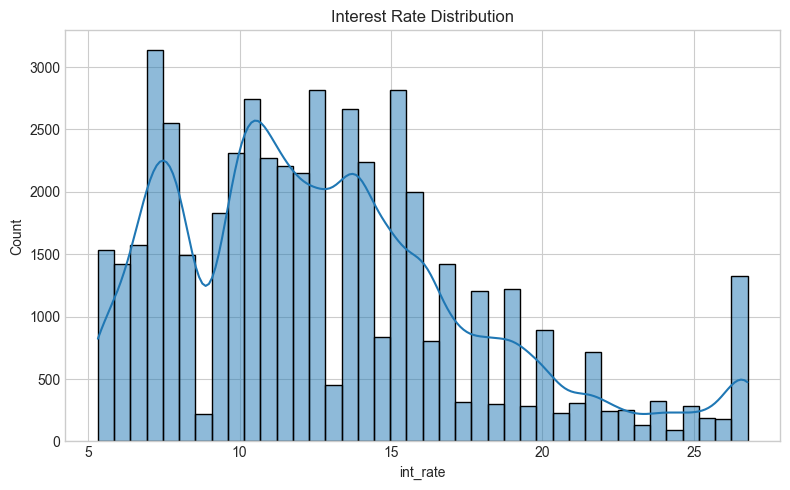

In [16]:
def tight():
    plt.tight_layout()

# Distribution of interest rate
if "int_rate" in acc_sub:
    plt.figure(figsize=(8,5))
    sns.histplot(acc_sub["int_rate"].dropna(), bins=40, kde=True)
    plt.title("Interest Rate Distribution")
    tight()

* **Range & shape:** Rates span roughly **5%–27%**, with a **right-skewed** distribution. Most volume sits in the **10–18%** band.
* **Discrete “spikes”:** The tall bars at specific rates aren’t noise—they reflect **discrete pricing buckets** (driven by **grade / sub_grade** and often **term**). The KDE smooths this, but the data are not continuous.
* **Multiple modes:** Several peaks suggest **tiers** (A/B/C vs D/E/F/G, and 36m vs 60m). Longer terms typically carry **higher rates**, contributing to the upper modes/tail.
* **Cap effect:** A visible pile-up near the high end (~26–27%) is consistent with a **platform cap**; few loans price above that.


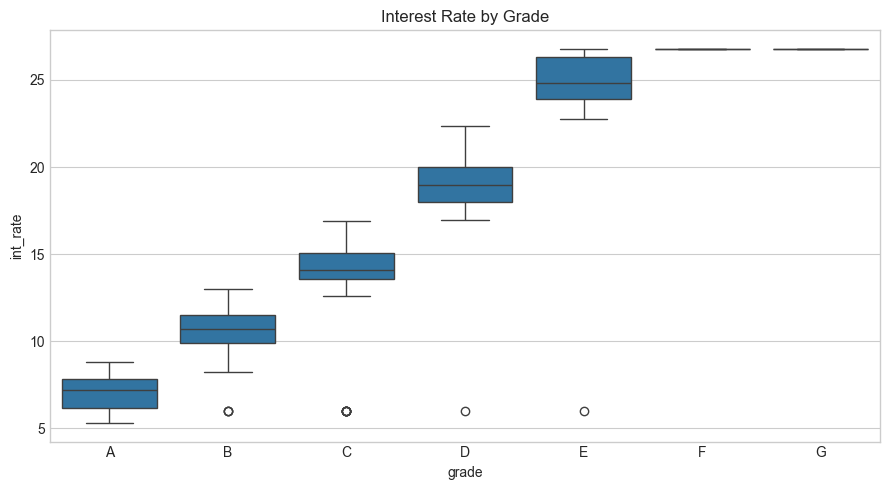

In [17]:
# Box: int_rate by grade
if {"int_rate","grade"} <= set(acc_sub.columns):
    plt.figure(figsize=(9,5))
    sns.boxplot(data=acc_sub, x="grade", y="int_rate", order=sorted(acc_sub["grade"].dropna().unique()))
    plt.title("Interest Rate by Grade")
    tight()

* **Strong monotonic pattern:** Median rate climbs steadily from **A (~7–9%)** to **G (~23–27%)**. That’s textbook: lower grades = higher priced = higher risk.
* **Separation:** Adjacent grades overlap a bit, but non-adjacent (e.g., A vs. D/E/F/G) are well separated → grades are meaningful tiers.
* **Wider spread at higher risk:** IQRs and whiskers get larger for **E–G**, indicating more heterogeneity among risky borrowers.
* **High-end cap:** Top whiskers flatten near **~26–27%**, consistent with pricing caps.

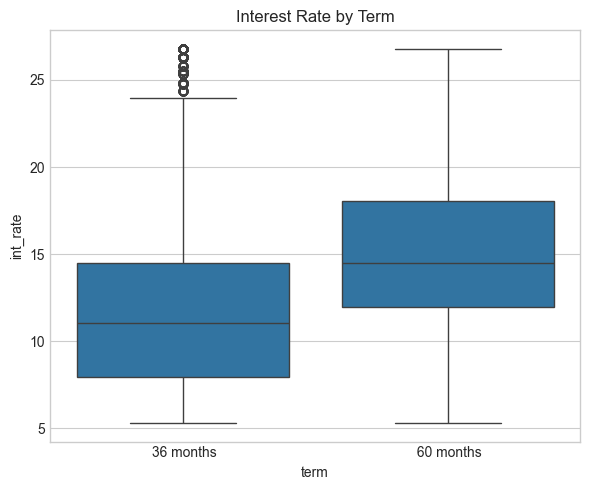

In [18]:
# Box: int_rate by term
if {"int_rate","term"} <= set(acc_sub.columns):
    plt.figure(figsize=(6,5))
    sns.boxplot(data=acc_sub, x="term", y="int_rate")
    plt.title("Interest Rate by Term")
    tight()

* **60-month loans carry higher rates** than 36-month loans. Median looks ~13–14% vs ~9–10% for 36m.
* **Wider spread for 60m**: bigger IQR and taller whiskers → more heterogeneity and more very high-rate loans.
* **High-end cap** visible again near ~26–27%.
* Interpretation: lenders price **term risk** (longer exposure, payment fatigue, prepay/default uncertainty). Also some **adverse selection**—riskier borrowers prefer longer terms → higher rates.

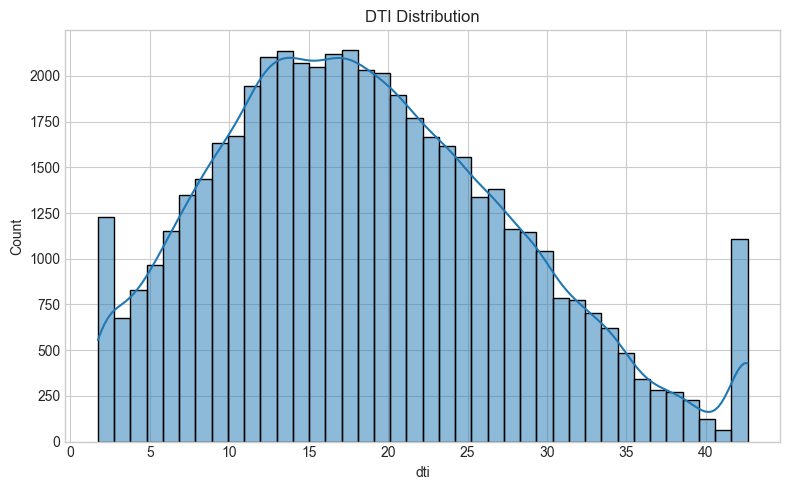

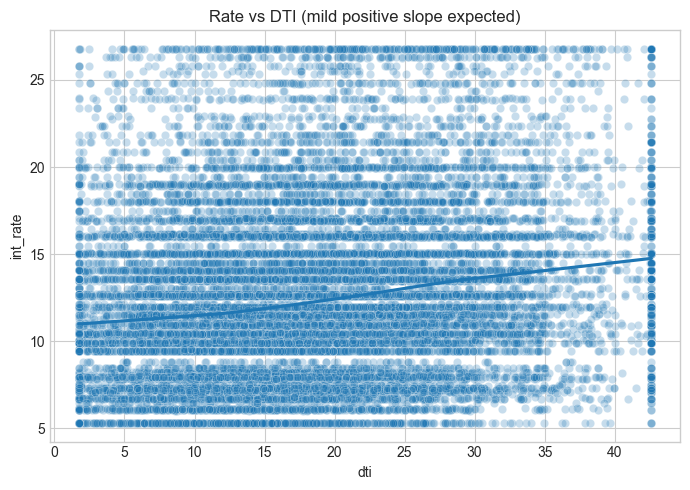

In [20]:
# DTI distribution and vs int_rate
if "dti" in acc_sub.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(acc_sub["dti"].dropna(), bins=40, kde=True)
    plt.title("DTI Distribution")
    tight()
if {"dti","int_rate"} <= set(acc_sub.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=acc_sub.sample(min(20000, len(acc_sub)), random_state=RANDOM_SEED),
                    x="dti", y="int_rate", alpha=0.25)
    sns.regplot(data=acc_sub, x="dti", y="int_rate", scatter=False, lowess=True)
    plt.title("Rate vs DTI (mild positive slope expected)")
    tight()

**DTI Distribution**

* **Shape:** Big mound in the middle (roughly **10–20 DTI**), tapering off toward higher DTIs. That’s typical: most accepted borrowers have **moderate leverage**.
* **Left spike near 0:** A noticeable pile at **DTI≈0–1**. Often debt-free applicants or occasional data quirks (e.g., zeroed DTIs). Keep an eye on it—could warrant a special bucket.
* **Right-end spike:** A sharp bump at the **upper limit (~40–43)** → classic **screening/cap effect** (many platforms cap acceptable DTI around 40–45). Values cluster at the cap because riskier applicants just inside the cutoff get accepted.

**Rate vs DTI**

* **Slight upward trend:** The LOWESS line slopes **gently up** → higher DTI borrowers tend to get **higher interest rates**, but the effect is **modest** compared with other drivers.
* **Horizontal bands:** Rates fall into **discrete tiers** (pricing buckets set by **grade / sub-grade** and **term**), so points stack in stripes. That’s why the cloud looks “striped.”
* **Right-edge pile-up:** A vertical cluster near **DTI ≈ 40–43** indicates a **DTI cap** in underwriting; many accepted loans sit right under that limit.
* **Selection effect:** This is **accepted loans only**. Pricing (rate) is downstream of the lender’s risk assessment, so DTI’s relationship with rate is **partly policy-driven** and confounded by **grade/term**.

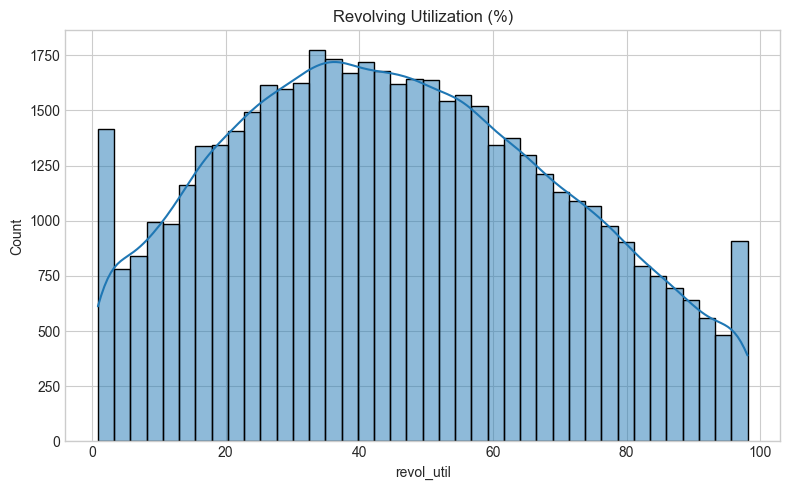

In [21]:
# Revolving utilization
if "revol_util" in acc_sub.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(acc_sub["revol_util"].dropna(), bins=40, kde=True)
    plt.title("Revolving Utilization (%)")
    tight()

**What the histogram says**

* **Bell-ish shape** centered around **~40–50%**: most borrowers use about half of their revolving credit.
* **Edge spikes** at **~0%** and **~100%**:

  * **0%** often means no revolving balance / newly opened lines / data set to zero → treat as a special group.
  * **~100%** means **maxed-out** lines—typically high risk.
* Long right tail into the **80–100%** zone → a non-trivial share is highly leveraged.


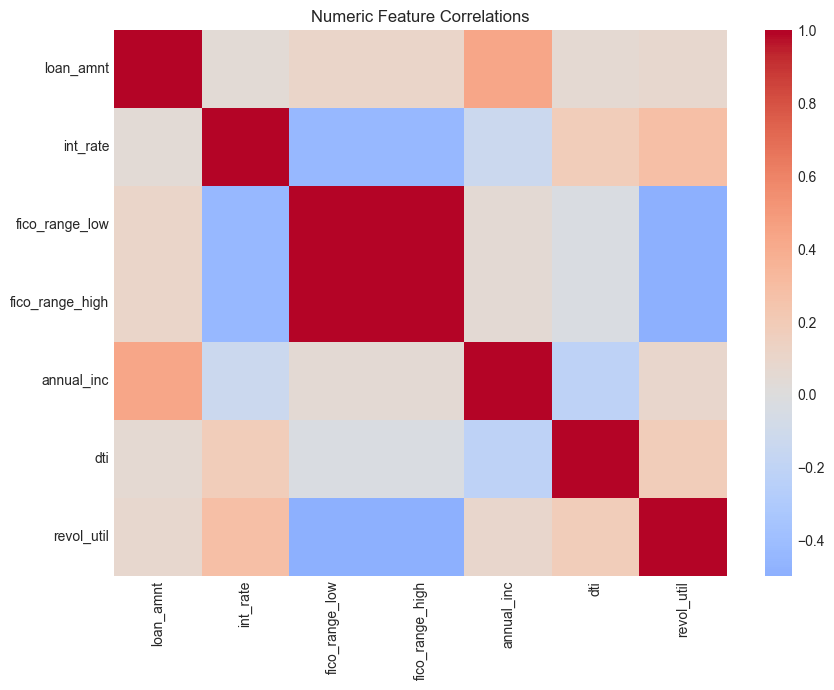

In [22]:
# Correlation heatmap
plt.figure(figsize=(9,7))
sns.heatmap(acc_sub[num_cols].corr(numeric_only=True), annot=False, cmap="coolwarm", center=0)
plt.title("Numeric Feature Correlations")
tight()

plt.show()

### Key relationships

* **`fico_range_low` ↔ `fico_range_high`:** **~1.0 (very high +)** → they’re essentially the same signal. Keep **one** (or use their mean).
* **`int_rate` ↔ FICO (low/high):** **Strong negative** → higher FICO → lower rate (as expected).
* **`dti` ↔ `revol_util`:** **Moderate/strong positive** → both capture leverage/credit usage.
* **`annual_inc` ↔ `dti`:** **Clear negative** → higher income → lower DTI.
* **`loan_amnt` ↔ `annual_inc`:** **Positive** → higher income supports larger loans.
* **`revol_util` ↔ FICO:** **Negative** → higher utilization associates with lower FICO.
* **`loan_amnt` ↔ `int_rate`:** Weak/slight **positive** → larger loans slightly pricier (mixed/confounded by grade/term).


# Conclusion

* **Pricing is tiered and discrete.** Interest rates span ~5%–27% with clear **buckets** (histogram stripes).
* **Grade drives price cleanly.** Boxplots show a **monotonic rise A→G**; spread grows in E–G (more heterogeneous risk).
* **Term matters.** **60-month loans** price higher and show wider dispersion than 36-month—term risk is priced in.
* **DTI distribution** is bell-shaped (10–25), with a **hard pile-up near the policy cap (~40–43)** and a small spike near **0**.
* **Revolving utilization** centers ~40–50% with spikes at **0%** and **~100%** (maxed-out lines).
* **Purpose mix is concentrated.** **Debt consolidation + credit card ≈ 77%** of volume; the rest are small tails.
* **Verification status groups differ.** “Verified” cohorts carry **higher median/mean rates** (selection into verification).
* **Correlations:**

  * FICO_low ≈ FICO_high (duplicate signal).
  * **int_rate ↘ FICO** (strong negative).
  * **DTI ↗ revol_util** (positive).
  * **annual_inc ↘ DTI**, **annual_inc ↗ loan_amnt**.

## Policy implications

* **Segment policies by grade & term.** Use tighter underwriting/oversight for **lower grades** and **60-month** terms; lighter touch for **A–B / 36-month**.
* **Codify DTI caps & flags.** Keep the cap (≈40–43) and **flag cap-edge DTIs** and **DTI≈0** for manual checks (data/behavioral anomalies).
* **Watch revolving utilization.** Add rules/flags for **util ≥90–100%** (maxed) and **util=0%** (thin/no-use files).
* **Prioritize ops where the volume is.** Ensure review/playbooks tailored to **debt consolidation & credit card** (most of the pipeline).
* **Verification workflows.** Since “Verified” cohorts skew pricier, **route them to documentation checks first**; for “Not Verified,” emphasize income/employment validation before pricing adjustments.
